# CNN Fashion MNIST

## Import Packages

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data

In [94]:
# load train data
train_dataset = torchvision.datasets.FashionMNIST(
    root='data/',
    train=True, # Will return the train dataset
    transform=transforms.ToTensor(), #preprocessing 
    download=True
)

In [95]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [96]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [97]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [98]:
train_dataset.targets.shape

torch.Size([60000])

In [99]:
# load test data
test_dataset = torchvision.datasets.FashionMNIST(
    root='data/',
    train=False, # Will return the test dataset
    transform=transforms.ToTensor(), #preprocessing 
    download=True
)

In [100]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [101]:
# get number of classes
K = len(set(train_dataset.targets.numpy()))
print("Number of classes:", K)

Number of classes: 10


## Build Model 

Using inheritance

In [119]:
class CNN(nn.Module): # makes oour class an offical pytorch module
    def __init__(self,K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )
    
    # https://pytorch.org/docs/stable/nn.html

    ## Layer 1
    # Hin 28, padding defaulted to 0, kernel = 3, stride = 2
    # floor((28 + 2*(0) - 1*(3-1) -1)/2 +1) => 13
    ## Layer 2
    # Hin 13, padding defaulted to 0, kernel = 3, stride = 2
    # floor((13 + 2*(0) - 1*(3-1) -1)/2 +1) => 6
    ## Layer 3
    # Hin 28, padding defaulted to 0, kernel = 3, stride = 2
    # floor((6 + 2*(0) - 1*(3-1) -1)/2 +1) => 2
    ## input to the dense layer 128*2*2


        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2,512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )

    def forward(self, X):
        out = self.conv_layers(X) # returns torch.Size([128, 128, 2, 2])
        # out = out.view(out.size(0), -1)
        #print("Out before:", out.shape)
        out = out.view(-1, 128*2*2) # returns torch.Size([128, 512])
        #print("Out after:", out.shape)
        out = self.dense_layers(out)
        return out


In [120]:
# instantiate the model
model = CNN(K)

In [121]:
# The same model! Using the newly introduced "Flatten"
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)

In [122]:
# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # check if GPU is available
print(device)
model.to(device) # transfer the model parameters and data to the GPU (or RAM in case of CPU)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [123]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() #combines the softmax
optimizer = torch.optim.Adam(model.parameters())

In [124]:
# Data loaders
# Generators that will generate batches for the training loop and takes care of shuffling

batch_size=128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

In [125]:
def batch_gd(model,criterion,optimizer,train_loader,test_loader,epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = [] # this will store loss per batch
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) # move data to GPU


            optimizer.zero_grad()

            #forward pass
            outputs = model(inputs)
            loss = criterion(outputs,targets)

            # backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item()) # this will loss of the batch

        #get train and test loss
        train_loss=np.mean(train_loss) # The mean can represent the loss for the epoch

        
        test_loss = []
        for inputs,targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device) # move data to GPU
            
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            test_loss.append(loss.item()) # this will loss of the batch

        test_loss=np.mean(test_loss) # The mean can represent the loss for the epoch

        # save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f},Duration: {dt}')
    return train_losses, test_losses

In [126]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

28, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after: torch.Size([128, 512])
Out before: torch.Size([128, 128, 2, 2])
Out after

KeyboardInterrupt: 

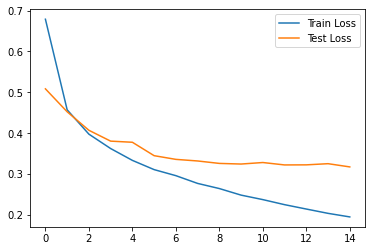

In [110]:
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend();

In [84]:
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [85]:
# Calculate Train Accuracy
n_correct = 0.
n_total = 0.
for inputs,targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device) # move data to GPU
    # reshape the input
    #inputs = inputs.view(-1, 784)
    
    # Forward pass
    outputs = model(inputs)

    # Get predictions
    # Since these are logits, get max
    # torch.max() returns both max and argmax
    # retunes the max vale and the corrosponding index. We only want the index
    _, predictions = torch.max(outputs, 1) 

    #update counts 
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct/n_total

# Calculate test accuracy
n_correct = 0.
n_total = 0.
for inputs,targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device) # move data to GPU
    # reshape the input
    #inputs = inputs.view(-1, 784)
    
    # Forward pass
    outputs = model(inputs)

    # Get predictions
    # Since these are logits, get max
    # torch.max() returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    #update counts 
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9471, Test acc: 0.8984


In [86]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[854   1  25  19   5   1  88   0   7   0]
 [  1 976   0  12   3   0   5   0   3   0]
 [ 18   1 849   8  66   0  54   0   4   0]
 [ 18   7  25 899  31   1  17   0   2   0]
 [  2   1  42  28 869   0  53   0   5   0]
 [  0   0   0   1   0 963   0  23   1  12]
 [109   0  62  22 121   0 672   0  14   0]
 [  0   0   0   0   0   8   0 954   0  38]
 [  2   1   1   5   8   2   1   2 977   1]
 [  1   0   0   0   0   3   0  25   0 971]]


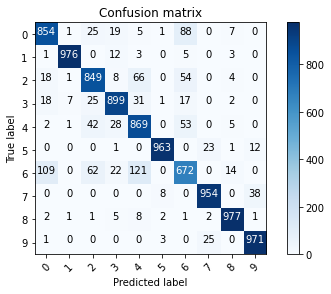

In [87]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)

  # reshape the input
  #inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

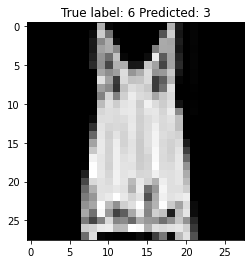

In [93]:
#Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));